In [1]:
import imp

import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl
import axelrod.interaction_utils as iu

import testzd as zd

C, D = axl.Action.C, axl.Action.D

In [2]:
parameters = imp.load_source('parameters', 'data/raw/parameters.py')

# Investigate whether or not a strategy is zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. This result showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

The question arises:

**Given a strategy $p$, is it a zero determinant strategy?**

This is equivalent to finding $\alpha, \beta, \gamma \in \mathbb{R}$ such that $\tilde p = \alpha S_x + \beta S_y + \gamma 1$.

Recall that $\tilde p, S_x, S_y, 1\in\mathbb{R}^{4\times 1}$ so this corresponds to a linear system of 4 equations on three variables.

$$\tilde p=Mx$$

Where:

$$
M = \begin{pmatrix}S_x, S_y, 1\end{pmatrix}\in\mathbb{R}^{4\times 3}
$$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

it is defined to ensure:

$$
\begin{aligned}
\alpha s_x - P &= 2(s_y - P)\\
\alpha s_x - 2s_y + P&=0\\
\end{aligned}
$$

Let us solve $Mx=\tilde p$

In [3]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
zd.is_delta_ZD(p, delta=10 ** -7)

True

Note that the following vector is not:

$$p = (8 / 9, 1, 1 / 3, 0)$$

In [4]:
zd.is_delta_ZD(np.array([8 / 9, 1, 1 / 3, 0]), delta=10 ** -7)

False

Furthermore we can simulate the play of strategies and measure the probabilities:

In [5]:
players = axl.ZDExtort2(), axl.Alternator()
match = axl.Match(players, turns=10 ** 6)
axl.seed(0)
interactions = match.play()

In [6]:
def get_p_from_interactions(interactions):
    state_counter = iu.compute_state_to_action_distribution(interactions)[0]
    p = []
    for state in ((C, C), (C, D), (D, C), (D, D)):
        try:
            p.append(state_counter[(state, C)] / (state_counter[(state, C)]  + state_counter[(state, D)] ) )
        except ZeroDivisionError:
            p.append(np.NaN)
    return np.array(p)

In [7]:
p = get_p_from_interactions(interactions=interactions)
p

array([0.88787388, 0.49963841, 0.33404832, 0.        ])

We see that that measure of $p$ is not $\delta$-ZD for $\delta=10 ^ {-7}$:

In [8]:
zd.is_delta_ZD(p, delta=10 ** -7)

False

However it is for $\epsilon=10 ^ {-2}$:

In [9]:
zd.is_delta_ZD(p, delta=10 ** -2)

True

In fact the lowest $\delta$ for which $p$ is $\delta$-ZD is $\delta=10 ^ {-3}$:

In [10]:
zd.compute_least_squares(p)

(array([ 0.05551368, -0.1113683 ,  0.05606306]), 7.820132773633553e-07)

## Dealing with missing states

When observing strategies it is possible that some pairs of strategies do not visit all potential states. For example a cooperator against a defector will never visit the state $(\text{D}, \text{C})$. On these occasions, the $\delta$-ZD definition can be modified. Given a set of visited states $S\subseteq \{\text{C}, \text{D}\} ^2$: we define:

$$
M', \tilde p'
$$

where $M', p'$ corresponds to the rows/elements of $M, \tilde p$ that are in $S$.

As before, we can then find the best fitting $\bar x=(\bar\alpha, \bar\beta, \bar\gamma)$ which minimises:

$$
R^2 = \|M' x-\tilde p'\|_2= \sum_{i\text{ corresponding to }S}\left((M\bar x)_i-\tilde p_i\right)^2
$$

For example let us consider a match between a cooperator and the `extort-2` strategy:

In [11]:
players = axl.ZDExtort2(), axl.Cooperator()
match = axl.Match(players, turns=10 ** 6)
axl.seed(0)
interactions = match.play()
p = get_p_from_interactions(interactions)
p

array([0.88902872,        nan, 0.3330999 ,        nan])

In [12]:
zd.is_delta_ZD(p, delta=10 ** -7)

True

Note however that in the case of $|S|>1$ (ie there are any missing states) then there exists a unique solution to the corresponding equations: thus, technically in the case of missing states **all** strategies are in fact $\delta$-ZD for all $\delta\geq 0$.

https://en.wikipedia.org/wiki/Rouch%C3%A9%E2%80%93Capelli_theorem

## Empirical observation

Let us measure the probabilities from two tournaments:

- The Stewart and Plotkin tournament of [2] which was written as a follow on to [1] highligting the impact of ZD strategies.
- A full tournament from the Axelrod Python project ([3] described in [4]): an open source library with over 200 strategies contributed from academics as well as the general public.

**TODO** Describe parameters etc...

## Evaluate the Press and Dyson tournament

Firslty let us look at the tournament of [2].

In [13]:
players = parameters.PLAYER_GROUPS["stewart_plotkin"]

player_names = [s.name for s in players]

df = pd.read_csv("data/processed/stewart_plotkin/std/overall/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (df["chi"] > 1)

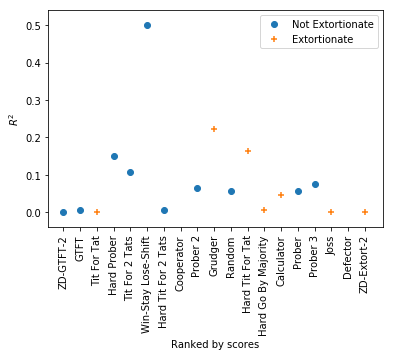

In [14]:
x_tick_locations = range(1, len(players) + 1)

for index, label, marker in zip([~df["Extort"], df["Extort"]], ["Not Extortionate", "Extortionate"], ("o", "+")):
    ranks = df["Score"].rank(ascending=False)[df["complete"] & index]
    plt.scatter(ranks, df[df["complete"] & index]["residual"], label=label, marker=marker)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Score"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.xlabel("Ranked by scores")
plt.ylabel(r"$R^2$")
plt.legend()
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

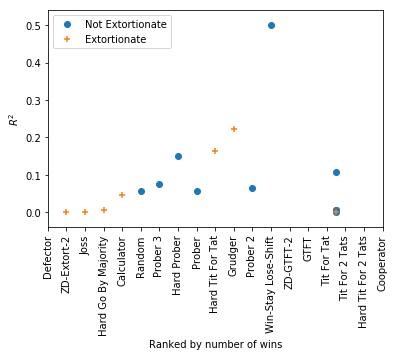

In [15]:
x_tick_locations = range(1, len(players) + 1)

for index, label, marker in zip([~df["Extort"], df["Extort"]], ["Not Extortionate", "Extortionate"], ("o", "+")):
    ranks = df["Win"].rank(ascending=False)[df["complete"] & index]
    plt.scatter(ranks, df[df["complete"] & index]["residual"], label=label, marker=marker)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Win"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.xlabel("Ranked by number of wins")
plt.ylabel(r"$R^2$")
plt.legend()
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

In [16]:
player_vectors = {i: np.array(row[["P(C|CC)", "P(C|CD)", "P(C|DC)", "P(C|DD)"]]).astype(float) 
                  for i, row in df.iterrows()}

We can also consider pair wise matches:

In [17]:
import itertools
data = []
for i, j in itertools.product(range(19), repeat=2):
    try:
        pi = zd.compute_pi(player_vectors[i], player_vectors[j])[:, 0]
        row = [i, j, pi[0], pi[1], pi[2], pi[3]]
    except np.linalg.LinAlgError:
        row = [i, j] + [np.nan, np.nan, np.nan, np.nan]
    data.append(row)
theoretic_df = pd.DataFrame(data, columns=["Player index", "Opponent index", "P(CC)", "P(CD)", "P(DC)", "P(DD)"])

In [18]:
df = pd.read_csv("data/processed/full/std/per_opponent/main.csv")
#df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
#df["Opponent name"] = df.apply(lambda row: player_names[row["Opponent index"]], axis=1)
#df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (df["chi"] > 1)

In [19]:
player_pair_vectors = {}
player_pair_probabilities = {}
for _, row in df.iterrows():
    pair = tuple(row[["Player index", "Opponent index"]])
    if pair[::-1] in player_pair_vectors:
        player_pair_vectors[pair[::-1]].append(tuple(row[["P(C|CC)", "P(C|CD)", "P(C|DC)", "P(C|DD)"]]))
    else:
        player_pair_vectors[pair] = [tuple(row[["P(C|CC)", "P(C|CD)", "P(C|DC)", "P(C|DD)"]])]
        player_pair_probabilities[pair] = tuple(row[["P(CC)", "P(CD)", "P(DC)", "P(DD)"]])

In [20]:
data = []
player_pair_theoretic_probabilities = {}
for i, j in player_pair_probabilities:
    try:
        p, q = player_pair_vectors[i, j]
    except ValueError:
        p = player_pair_vectors[i, j][0]
        q = p
    try:
        pi = zd.compute_pi(np.array(p), np.array(q))[:, 0]
        
    except np.linalg.LinAlgError:
        pi = [np.nan, np.nan, np.nan, np.nan]
    data.append([i, j, *pi, *player_pair_probabilities[i, j]])
df = pd.DataFrame(data, columns=["Player index", 
                                 "Opponent index",
                                 "theoretic P(CC)",
                                 "theoretic P(CD)",
                                 "theoretic P(DC)",
                                 "theoretic P(DD)",
                                 "P(CC)",
                                 "P(CD)",
                                 "P(DC)",
                                 "P(DD)",
                                ])

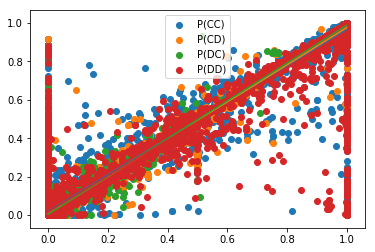

In [21]:
df.dropna(inplace=True)
plt.figure()
for state in ("CC", "CD", "DC", "DD"):
    prob = f"P({state})"
    index = np.isfinite(df[prob]) & (df[f"theoretic {prob}"] >= 0) & (df[f"theoretic {prob}"] <= 1)
    y = df[index][prob]
    x = df[index][f"theoretic {prob}"]
    line = np.poly1d(np.polyfit(x, y, 1))
    plt.scatter(x, y, label=prob)
    plt.plot([0, 1], [line(0), line(1)])
plt.legend()

In [29]:
import statsmodels.api as sm

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.pvalues

const              9.990082e-33
theoretic P(DD)    0.000000e+00
dtype: float64

In [30]:
results.rsquared

0.9364316681216069

In [53]:
b, a = results.params

In [54]:
results.params

const              0.016120
theoretic P(DD)    0.937949
dtype: float64

In [55]:
b, a

(0.01612001830685652, 0.9379489555855542)

In [49]:
results.nobs

9422.0

In [47]:
results.fittedvalues

1        0.017997
2        0.954069
3        0.017996
4        0.016120
5        0.485094
7        0.044357
8        0.016120
9        0.016120
10       0.017997
11       0.017997
12       0.016120
13       0.894455
14       0.844445
16       0.246846
17       0.870850
18       0.017528
20       0.683712
21       0.033885
22       0.890973
23       0.375224
25       0.484859
27       0.017997
29       0.016120
31       0.172366
32       0.250842
33       0.328613
34       0.485094
35       0.641576
36       0.328613
40       0.485094
           ...   
20859    0.369317
20860    0.357807
20861    0.484156
20866    0.061088
20867    0.050933
20869    0.920106
20870    0.947038
20871    0.951054
20875    0.954069
20879    0.938565
20880    0.954069
20883    0.908938
20884    0.849214
20885    0.600556
20886    0.954069
20890    0.953673
20892    0.682063
20893    0.837643
20895    0.459325
20897    0.948954
20898    0.616047
20899    0.039474
20900    0.890636
20901    0.020159
20902    0

In [117]:
df = pd.read_csv("data/processed/stewart_plotkin/std/per_opponent/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Opponent name"] = df.apply(lambda row: player_names[row["Opponent index"]], axis=1)
df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (df["chi"] > 1)

delta_array = np.zeros((len(players), len(players)))
mutual_cooperation_array = np.zeros((len(players), len(players)))

for array in [delta_array, mutual_cooperation_array]:
    array.fill(np.nan)

for index, row in df.iterrows():
    if row["Extort"]:
        delta_array[row["Player index"], row["Opponent index"]] = row["residual"]
    mutual_cooperation_array[row["Player index"], row["Opponent index"]] = row["P(CC)"]

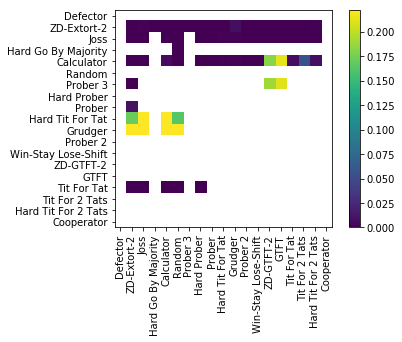

In [118]:
plt.imshow(delta_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

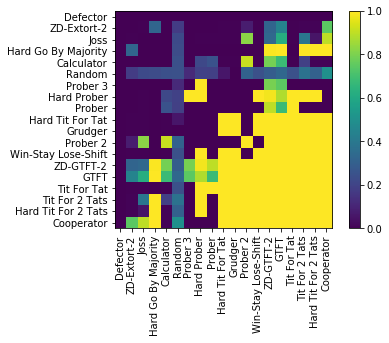

In [119]:
plt.imshow(mutual_cooperation_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

## Larger tournament

In [120]:
df = pd.read_csv("data/processed/full/std/overall/main.csv")
players = parameters.PLAYER_GROUPS["full"]
player_names = [s.name for s in players]
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (- df["beta"] / df["alpha"] > 1)
df.sort_values("Score", ascending=False)

,Player index,complete,Score,Win,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),residual,alpha,beta,gamma,chi,Player name,Extort
56,56,True,72073078,2818,0.938130,0.498445,0.207358,0.469810,0.673403,0.071022,0.163504,0.092071,4.230097e-02,-0.086267,-0.228050,7.356495e-01,-2.643528,EvolvedLookerUp2_2_2,False
57,57,True,72066777,2511,0.999799,0.465548,0.002483,0.188178,0.717565,0.039248,0.133415,0.109771,8.701581e-02,-0.028165,-0.135553,2.823676e-01,-4.812722,Evolved HMM 5,False
129,129,True,71312376,2495,0.965593,0.182812,0.183294,0.347217,0.623888,0.068531,0.179908,0.127673,1.269716e-01,-0.037352,-0.237448,5.380287e-01,-6.357097,PSO Gambler 2_2_2,False
131,131,True,71175945,2585,1.000000,0.522486,0.000000,0.120535,0.715043,0.032669,0.123978,0.128309,6.426871e-02,-0.012259,-0.107762,1.808025e-01,-8.790363,PSO Gambler Mem1,False
128,128,True,71143493,2705,1.000000,0.282533,0.000000,0.131962,0.696042,0.026936,0.131716,0.145306,1.363980e-01,-0.004769,-0.148262,1.979425e-01,-31.091507,PSO Gambler 1_1_1,False
52,52,True,70988717,2263,0.992589,0.470453,0.000000,0.682802,0.687791,0.087570,0.149427,0.075212,1.642911e-01,-0.167367,-0.273276,1.027908e+00,-1.632798,Evolved FSM 4,False
50,50,True,70816631,2751,0.999898,0.930344,0.001421,0.000000,0.681514,0.003970,0.129917,0.184599,1.030060e-03,0.003300,-0.010916,5.093289e-05,3.307901,Evolved ANN 5,True
54,54,True,70648934,2595,0.998337,0.637264,0.038748,0.011906,0.706600,0.015060,0.118442,0.159899,2.382690e-02,0.018565,-0.061732,1.868988e-02,3.325229,Evolved FSM 16 Noise 05,False
53,53,True,70436701,3723,0.928119,0.668755,0.249082,0.192369,0.619020,0.074277,0.174879,0.131823,1.105318e-03,-0.011948,-0.128013,3.244936e-01,-10.714416,Evolved FSM 16,False
49,49,True,70201223,2727,0.999668,0.146135,0.036341,0.085944,0.671552,0.022939,0.133386,0.172124,1.643549e-01,0.019674,-0.158367,1.290819e-01,8.049623,Evolved ANN,False


In [121]:
df["residual"].describe()

count    202.000000
mean       0.088426
std        0.148468
min        0.000000
25%        0.001624
50%        0.033496
75%        0.136292
max        1.388889
Name: residual, dtype: float64

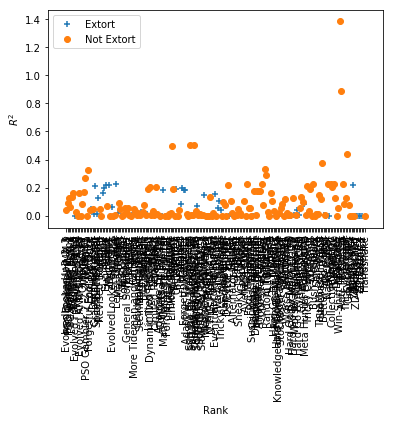

In [122]:
x_tick_locations = range(1, len(players) + 1)

for index, label, marker in zip([df["Extort"], ~df["Extort"]], ["Extort", "Not Extort"], ("+", "o")):
    ranks = df["Score"].rank(ascending=False)[df["complete"] & index]
    plt.scatter(ranks, df[df["complete"] & index]["residual"], label=label, marker=marker)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Score"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.xlabel("Rank")
plt.ylabel(r"$R^2$")
plt.legend()
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

In [123]:
df.sort_values("Score", ascending=False).head(20)

,Player index,complete,Score,Win,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),residual,alpha,beta,gamma,chi,Player name,Extort
56,56,True,72073078,2818,0.938130,0.498445,0.207358,0.469810,0.673403,0.071022,0.163504,0.092071,0.042301,-0.086267,-0.228050,7.356495e-01,-2.643528,EvolvedLookerUp2_2_2,False
57,57,True,72066777,2511,0.999799,0.465548,0.002483,0.188178,0.717565,0.039248,0.133415,0.109771,0.087016,-0.028165,-0.135553,2.823676e-01,-4.812722,Evolved HMM 5,False
129,129,True,71312376,2495,0.965593,0.182812,0.183294,0.347217,0.623888,0.068531,0.179908,0.127673,0.126972,-0.037352,-0.237448,5.380287e-01,-6.357097,PSO Gambler 2_2_2,False
131,131,True,71175945,2585,1.000000,0.522486,0.000000,0.120535,0.715043,0.032669,0.123978,0.128309,0.064269,-0.012259,-0.107762,1.808025e-01,-8.790363,PSO Gambler Mem1,False
128,128,True,71143493,2705,1.000000,0.282533,0.000000,0.131962,0.696042,0.026936,0.131716,0.145306,0.136398,-0.004769,-0.148262,1.979425e-01,-31.091507,PSO Gambler 1_1_1,False
52,52,True,70988717,2263,0.992589,0.470453,0.000000,0.682802,0.687791,0.087570,0.149427,0.075212,0.164291,-0.167367,-0.273276,1.027908e+00,-1.632798,Evolved FSM 4,False
50,50,True,70816631,2751,0.999898,0.930344,0.001421,0.000000,0.681514,0.003970,0.129917,0.184599,0.001030,0.003300,-0.010916,5.093289e-05,3.307901,Evolved ANN 5,True
54,54,True,70648934,2595,0.998337,0.637264,0.038748,0.011906,0.706600,0.015060,0.118442,0.159899,0.023827,0.018565,-0.061732,1.868988e-02,3.325229,Evolved FSM 16 Noise 05,False
53,53,True,70436701,3723,0.928119,0.668755,0.249082,0.192369,0.619020,0.074277,0.174879,0.131823,0.001105,-0.011948,-0.128013,3.244936e-01,-10.714416,Evolved FSM 16,False
49,49,True,70201223,2727,0.999668,0.146135,0.036341,0.085944,0.671552,0.022939,0.133386,0.172124,0.164355,0.019674,-0.158367,1.290819e-01,8.049623,Evolved ANN,False


In [124]:
df.sort_values("Score", ascending=False).head(20)

,Player index,complete,Score,Win,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),residual,alpha,beta,gamma,chi,Player name,Extort
56,56,True,72073078,2818,0.938130,0.498445,0.207358,0.469810,0.673403,0.071022,0.163504,0.092071,0.042301,-0.086267,-0.228050,7.356495e-01,-2.643528,EvolvedLookerUp2_2_2,False
57,57,True,72066777,2511,0.999799,0.465548,0.002483,0.188178,0.717565,0.039248,0.133415,0.109771,0.087016,-0.028165,-0.135553,2.823676e-01,-4.812722,Evolved HMM 5,False
129,129,True,71312376,2495,0.965593,0.182812,0.183294,0.347217,0.623888,0.068531,0.179908,0.127673,0.126972,-0.037352,-0.237448,5.380287e-01,-6.357097,PSO Gambler 2_2_2,False
131,131,True,71175945,2585,1.000000,0.522486,0.000000,0.120535,0.715043,0.032669,0.123978,0.128309,0.064269,-0.012259,-0.107762,1.808025e-01,-8.790363,PSO Gambler Mem1,False
128,128,True,71143493,2705,1.000000,0.282533,0.000000,0.131962,0.696042,0.026936,0.131716,0.145306,0.136398,-0.004769,-0.148262,1.979425e-01,-31.091507,PSO Gambler 1_1_1,False
52,52,True,70988717,2263,0.992589,0.470453,0.000000,0.682802,0.687791,0.087570,0.149427,0.075212,0.164291,-0.167367,-0.273276,1.027908e+00,-1.632798,Evolved FSM 4,False
50,50,True,70816631,2751,0.999898,0.930344,0.001421,0.000000,0.681514,0.003970,0.129917,0.184599,0.001030,0.003300,-0.010916,5.093289e-05,3.307901,Evolved ANN 5,True
54,54,True,70648934,2595,0.998337,0.637264,0.038748,0.011906,0.706600,0.015060,0.118442,0.159899,0.023827,0.018565,-0.061732,1.868988e-02,3.325229,Evolved FSM 16 Noise 05,False
53,53,True,70436701,3723,0.928119,0.668755,0.249082,0.192369,0.619020,0.074277,0.174879,0.131823,0.001105,-0.011948,-0.128013,3.244936e-01,-10.714416,Evolved FSM 16,False
49,49,True,70201223,2727,0.999668,0.146135,0.036341,0.085944,0.671552,0.022939,0.133386,0.172124,0.164355,0.019674,-0.158367,1.290819e-01,8.049623,Evolved ANN,False


In [203]:
df = pd.read_csv("data/processed/full/std/per_opponent/main.csv")

df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (df["chi"] > 1)
players = parameters.PLAYER_GROUPS["full"]
delta_array = np.zeros((len(players), len(players)))
mutual_cooperation_array = np.zeros((len(players), len(players)))

for array in [delta_array, mutual_cooperation_array]:
    array.fill(np.nan)

for index, row in df.iterrows():
    if row["Extort"]:
        delta_array[row["Player index"], row["Opponent index"]] = row["residual"]
    mutual_cooperation_array[row["Player index"], row["Opponent index"]] = row["P(CC)"]

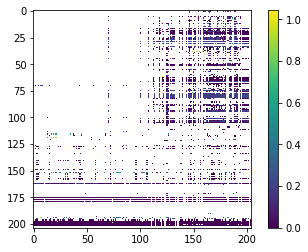

In [204]:
plt.imshow(delta_array[sorted_indices][:,sorted_indices])
plt.colorbar()

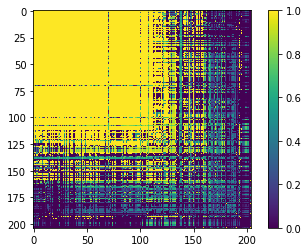

In [205]:
plt.imshow(mutual_cooperation_array[sorted_indices][:,sorted_indices])
plt.colorbar();
#plt.xticks(range(len(sorted_players)), sorted_players, rotation='vertical')
#plt.yticks(range(len(sorted_players)), sorted_players);

In [197]:
ranked_indices

[126,
 64,
 195,
 63,
 138,
 178,
 114,
 159,
 188,
 15,
 88,
 82,
 84,
 132,
 122,
 21,
 176,
 59,
 18,
 168,
 169,
 162,
 128,
 28,
 53,
 113,
 181,
 65,
 120,
 146,
 111,
 161,
 160,
 164,
 182,
 192,
 154,
 45,
 202,
 110,
 184,
 72,
 19,
 71,
 129,
 124,
 46,
 27,
 102,
 9,
 6,
 10,
 5,
 8,
 7,
 31,
 0,
 1,
 175,
 52,
 125,
 17,
 16,
 81,
 78,
 69,
 135,
 136,
 33,
 42,
 83,
 115,
 91,
 85,
 86,
 90,
 92,
 189,
 20,
 11,
 193,
 56,
 34,
 49,
 74,
 203,
 142,
 158,
 155,
 153,
 144,
 121,
 97,
 101,
 100,
 130,
 187,
 105,
 66,
 177,
 23,
 145,
 35,
 43,
 73,
 61,
 57,
 67,
 179,
 25,
 29,
 39,
 50,
 47,
 180,
 96,
 99,
 107,
 12,
 76,
 133,
 166,
 190,
 134,
 117,
 140,
 139,
 141,
 4,
 2,
 14,
 3,
 94,
 112,
 185,
 109,
 137,
 143,
 55,
 80,
 75,
 79,
 24,
 70,
 119,
 131,
 171,
 60,
 26,
 93,
 118,
 40,
 32,
 150,
 157,
 22,
 77,
 51,
 147,
 174,
 127,
 116,
 194,
 152,
 38,
 183,
 173,
 103,
 89,
 68,
 98,
 108,
 165,
 191,
 106,
 170,
 104,
 62,
 36,
 48,
 123,
 13,
 149,
 186

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.

[3] Golub, Gene H., and Charles F. Van Loan. Matrix computations. Vol. 3. JHU Press, 2012.

[4] The Axelrod project developers. Axelrod: v4.2.0. 2016. http://doi.org/10.5281/zenodo.1252994

[5] Knight, Vincent, et al. "An Open Framework for the Reproducible Study of the Iterated Prisoner’s Dilemma." Journal of Open Research Software 4.1 (2016).